In [1]:
from collections import defaultdict
from functools import reduce
from itertools import product, combinations
from time import time

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

In [2]:
n_units = 3
data = np.random.binomial(n=1, p=np.random.uniform(size=n_units), size=(100, n_units))
all_configs = list(product([0, 1], repeat=n_units))
alpha = .001

biases = np.random.randn(n_units)
weights = np.random.randn(n_units, n_units)

var_combinations = list(combinations(range(n_units), 2))


def reset_parameters():
    np.random.seed(42)
    biases = np.random.randn(n_units)
    weights = np.random.randn(n_units, n_units)
    return weights, biases

In [3]:
class Model:
    
    def __init__(self, weights, biases):
        self.weights = weights
        self.biases = biases
        
    def H(self, x):
        h = 0
        for i, j in var_combinations:
            h += self.weights[i, j] * x[i] * x[j]
        h += self.biases @ x
        return h
    
    def _unnormalized_likelihood(self, x):
        return np.exp(self.H(x))
    
    def marginal_likelihood(self, x):
        unnormalized_lik = 0
        for config in product(*[[0, 1] if el == ... else [el] for el in x]):
            config = np.array(config)
            unnormalized_lik += np.exp(self.H(config))
        return unnormalized_lik
    
    def likelihood(self, x, log=False):
        """
        Must have the dimensionality of the data observations. To marginalize, put ellipses (...)
        in the elements over which you wish to marginalize.
        """
        x = np.array(x)
        if not n_units in x.shape and len(x.shape) in (1, 2):
            raise('Please pass 1 or more points of `n_units` dimensions')
           
        # compute unnormalized likelihoods
        multiple_samples = len(x.shape) == 2
        if multiple_samples:
            likelihood = [self._unnormalized_likelihood(point) for point in x]
        else:
            likelihood = [self._unnormalized_likelihood(x)]
        
        # compute partition function
        Z = sum([self._unnormalized_likelihood(config) for config in all_configs])
        
        if log:
            return sum([np.log(lik) - np.log(Z) for lik in likelihood])
        else:
            return reduce(np.multiply, [lik / Z for lik in likelihood])
    
    def conditional_likelihood(x, cond: dict):
        joint = np.array(x)
        for index, val in cond.items():
            if isinstance(joint[index], int):
                raise
            joint[index] = val

        evidence = [cond.get(i, ...) for i in range(len(x))]

        return self._unnormalized_likelihood(joint) / self.marginal_likelihood(evidence)

# sample from model

In [34]:
def inv_logit(z):
    return 1 / (1 + np.exp(-z))


def gibbs_sampler(weights, biases, init_sample=None, n_samples=100, burn_in=25, every_n=10) -> np.array:
    
    if burn_in > n_samples:
        raise("Can't burn in for more samples than there are in the chain")
    
    if init_sample is None:
        init_sample = [0 for _ in biases]
    
    samples = [init_sample]
    
    def _gibbs_step(sample, i):
        z = sum([weights[i, j] * sample[j] for j in range(len(sample)) if j != i]) + biases[i]
        p = inv_logit(z)
        return np.random.binomial(n=1, p=p)
    
    for _ in range(n_samples):
        sample = list(samples[-1])  # make copy
        for i, _ in enumerate(sample):
            sample[i] = _gibbs_step(sample=sample, i=i)
        samples.append( sample )
        
    return np.array([sample for i, sample in enumerate(samples[burn_in:]) if i % every_n == 0])

# update parameters

In [5]:
from itertools import combinations


# using the expectation of gibbs samples to approximate negative phase

def update_parameters_with_gibbs_sampling(weights=weights, biases=biases, n_samples=100):
    model_samples = gibbs_sampler(weights=weights, biases=biases, n_samples=n_samples)

    for i, j in var_combinations:
        # positive phase
        positive_phase = (data[:, i] * data[:, j]).mean()

        # negative phase
        negative_phase = (model_samples[:, i] * model_samples[:, j]).mean()

        # update weights
        weights[i, j] += alpha * (positive_phase - negative_phase)
        
    for i, _ in enumerate(biases):
        # positive phase
        positive_phase = data[:, i].mean()
        
        # negative phase
        negative_phase = model_samples[:, i].mean()
        
        # update biases
        biases[i] += alpha * (positive_phase - negative_phase)
        
    return np.array(weights), np.array(biases)


# using full model expectation to compute negative phase
def update_parameters_with_true_negative_phase(weights=weights, biases=biases):
    model = Model(weights=weights, biases=biases)
    model_distribution = [(np.array(config), model.likelihood(config)) for config in all_configs]

    for i, j in var_combinations:
        # positive phase
        positive_phase = (data[:, i] * data[:, j]).mean()

        # negative phase
        negative_phase = sum([config[i] * config[j] * likelihood for config, likelihood in model_distribution])

        # update weights
        weights[i, j] += alpha * (positive_phase - negative_phase)
        
    for i, _ in enumerate(biases):
        # positive phase
        positive_phase = data[:, i].mean()
        
        # negative phase
        negative_phase = sum([config[i] * likelihood for config, likelihood in model_distribution])
        
        # update biases
        biases[i] += alpha * (positive_phase - negative_phase)
        
    return np.array(weights), np.array(biases)

# train model

In [7]:
weights, biases = reset_parameters()


for i in range(100):
    weights, biases = update_parameters_with_gibbs_sampling(weights=weights, biases=biases)
    
    lik = Model(weights=weights, biases=biases).likelihood(data, log=True)
    if i % 10 == 0:
        print(lik)

-181.30819308204985
-180.9944066279601
-180.76739118327933
-180.5329009178584
-180.3186431840651
-180.0480659876875
-179.839073071066
-179.582937353215
-179.33876082137095
-179.09070605650084


# plot samples

In [8]:
def plot_n_samples(n, weights=weights, biases=biases):
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    
    samples = gibbs_sampler(n_samples=n, weights=weights, biases=biases)
    x, y, z = zip(*np.array(samples))
    
    x += np.random.randn(len(x)) * .02
    y += np.random.randn(len(y)) * .02
    z += np.random.randn(len(z)) * .02
    
    ax.scatter(x, y, z)

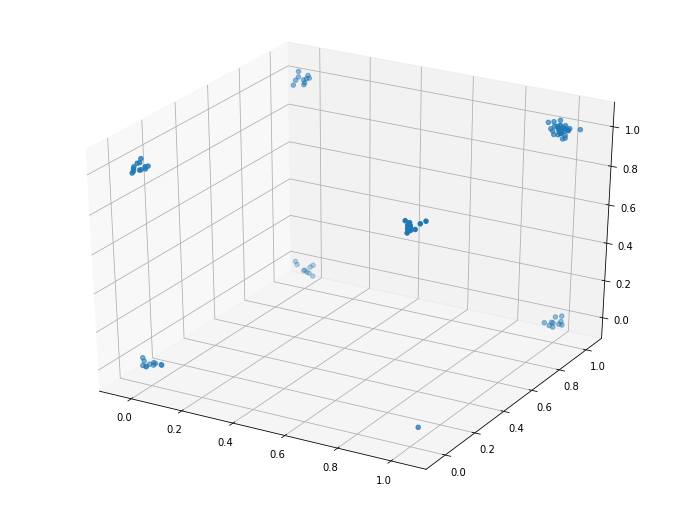

In [38]:
plot_n_samples(1000, weights=weights, biases=biases)

# now, derivation of gradient updates

# compare true distribution with gibbs chain

In [10]:
model = Model(weights=weights, biases=biases)

distribution = [(np.array(config), model.likelihood(config)) for config in all_configs]
distribution

[(array([0, 0, 0]), 0.08801601725974285),
 (array([0, 0, 1]), 0.1724456906919486),
 (array([0, 1, 0]), 0.07427352117800749),
 (array([0, 1, 1]), 0.08972223886254077),
 (array([1, 0, 0]), 0.14770735205456972),
 (array([1, 0, 1]), 0.23622495410737512),
 (array([1, 1, 0]), 0.09647802761861413),
 (array([1, 1, 1]), 0.09513219822720115)]

In [11]:
model_samples = gibbs_sampler(weights=weights, biases=biases, n_samples=1000)

empirical_dist = defaultdict(int)
for sample in model_samples:
    empirical_dist[tuple(sample)] += 1 / len(model_samples)
    
empirical_dist  

defaultdict(int,
            {(0, 0, 1): 0.18367346938775514,
             (1, 1, 1): 0.306122448979592,
             (1, 1, 0): 0.1020408163265306,
             (1, 0, 1): 0.09183673469387754,
             (0, 1, 0): 0.1020408163265306,
             (0, 1, 1): 0.09183673469387754,
             (0, 0, 0): 0.07142857142857142,
             (1, 0, 0): 0.0510204081632653})

In [12]:
for val, prob in distribution:
    empirical_prob = empirical_dist[tuple(val)]
    print(f'Value: {val}')
    print(f'True probability: {prob}')
    print(f'Empirical probability: {empirical_prob}')
    print(f'Abs difference: {np.abs(prob - empirical_prob)}')
    print('\n')

Value: [0 0 0]
True probability: 0.08801601725974285
Empirical probability: 0.07142857142857142
Abs difference: 0.01658744583117143


Value: [0 0 1]
True probability: 0.1724456906919486
Empirical probability: 0.18367346938775514
Abs difference: 0.011227778695806545


Value: [0 1 0]
True probability: 0.07427352117800749
Empirical probability: 0.1020408163265306
Abs difference: 0.027767295148523108


Value: [0 1 1]
True probability: 0.08972223886254077
Empirical probability: 0.09183673469387754
Abs difference: 0.002114495831336771


Value: [1 0 0]
True probability: 0.14770735205456972
Empirical probability: 0.0510204081632653
Abs difference: 0.09668694389130442


Value: [1 0 1]
True probability: 0.23622495410737512
Empirical probability: 0.09183673469387754
Abs difference: 0.14438821941349758


Value: [1 1 0]
True probability: 0.09647802761861413
Empirical probability: 0.1020408163265306
Abs difference: 0.0055627887079164745


Value: [1 1 1]
True probability: 0.09513219822720115
Empirica

# compare sampling algorithms

## via approximating negative phase via gibbs sampling

In [13]:
updates = []

In [14]:
weights, biases = reset_parameters()

timestamps = []
for i in range(100):
    timestamps.append(time())
    weights, biases = update_parameters_with_gibbs_sampling(weights=weights, biases=biases)
    
    lik = Model(weights=weights, biases=biases).likelihood(data, log=True)
    if i % 10 == 0:
        print(lik)
        
    updates.append( {'likelihood': lik, 'algo': 'update_parameters_with_gibbs_sampling', 'step': i, 'time': timestamps[-1] - timestamps[0]})

-181.30819308204985
-180.9944066279601
-180.76739118327933
-180.5329009178584
-180.3186431840651
-180.0480659876875
-179.839073071066
-179.582937353215
-179.33876082137095
-179.09070605650084


## via computing true negative phase

In [15]:
weights, biases = reset_parameters()

timestamps = []
for i in range(100):
    timestamps.append(time())
    weights, biases = update_parameters_with_true_negative_phase(weights=weights, biases=biases)
    
    lik = Model(weights=weights, biases=biases).likelihood(data, log=True)
    if i % 10 == 0:
        print(lik)
        
    updates.append( {'likelihood': lik, 'algo': 'update_parameters_with_true_negative_phase', 'step': i, 'time': timestamps[-1] - timestamps[0]})

-181.3218845245857
-181.03761802748738
-180.75575833777287
-180.47628829270974
-180.1991907647275
-179.92444866331343
-179.65204493686835
-179.38196257452756
-179.1141846079433
-178.848694113027


In [16]:
df = pd.DataFrame(updates)

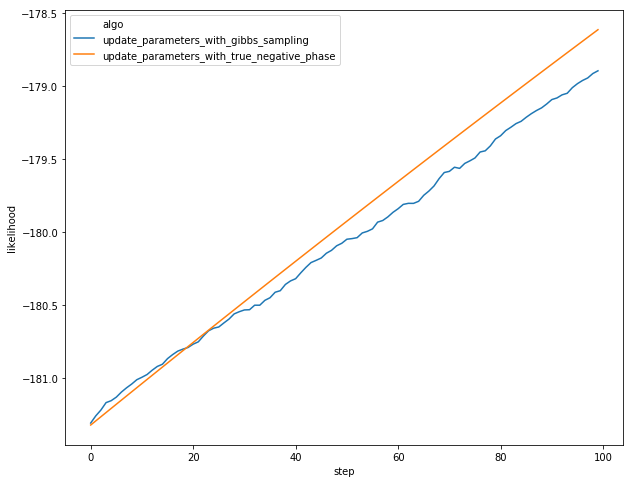

In [17]:
plt.figure(figsize=(10, 8))
ax = sns.lineplot(x="step", y="likelihood", hue="algo", legend='brief', data=df, ci=None)

In [18]:
# plt.figure(figsize=(10, 8))
# ax = sns.lineplot(x="time", y="likelihood", hue="algo", legend='brief', data=df)

# run both for 10 seconds

## via approximating negative phase via gibbs sampling

In [19]:
updates = []

In [20]:
weights, biases = reset_parameters()

timestamps = []
elapsed = 0
while elapsed < 10:
    timestamps.append(time())
    weights, biases = update_parameters_with_gibbs_sampling(weights=weights, biases=biases)
    elapsed = timestamps[-1] - timestamps[0]
    
    lik = Model(weights=weights, biases=biases).likelihood(data, log=True)
    if len(timestamps) % 100 == 0:
        print(lik)
        
    updates.append( {'likelihood': lik, 'algo': 'update_parameters_with_gibbs_sampling', 'step': i, 'time': elapsed})

-178.89348421112612
-176.93123247136174
-175.04058657159044
-173.30663471806736
-171.52552756053515
-170.07785653298498
-168.80174293776477
-167.5076719062795
-166.18104173789624
-165.2069615994423
-164.30262146559576
-163.52962797920145
-162.7981375669663
-162.26157215392618
-161.91135155056352
-161.56469850937344
-161.38907539187693
-161.21727024662053
-161.07559342881805
-160.9956503629833
-160.96072460666835
-161.00520568000934
-161.0416586488911
-161.16694716119977
-161.30806434914632
-161.6650847193992
-161.88462242941125
-162.17708306310286
-162.4288799102049
-162.77433037254534


## via computing true negative phase

In [21]:
weights, biases = reset_parameters()

timestamps = []
elapsed = 0
while elapsed < 10:
    timestamps.append(time())
    weights, biases = update_parameters_with_true_negative_phase(weights=weights, biases=biases)
    elapsed = timestamps[-1] - timestamps[0]
    
    lik = Model(weights=weights, biases=biases).likelihood(data, log=True)
    if len(timestamps) % 100 == 0:
        print(lik)
        
    updates.append( {'likelihood': lik, 'algo': 'update_parameters_with_true_negative_phase', 'elapsed': elapsed, 'step': i, 'time': elapsed})

-178.6116945051357
-176.09852960571646
-173.79442121534646
-171.6834692769892
-169.75050979275719
-167.9811900585003
-166.36201514217763
-164.88036986159364
-163.52452058332526
-162.28360097080866
-161.1475854465197
-160.1072536763678
-159.1541488916892
-158.28053237678097
-157.4793359947252
-156.7441142167387
-156.06899676748614
-155.44864270174733
-154.8781964837326
-154.3532464442719
-153.8697858369578
-153.42417659586616
-153.01311580862432
-152.63360485386949
-152.28292110664285
-151.95859208491692
-151.65837189174195
-151.38021979763968
-151.12228080454247
-150.88286803400635
-150.66044678716264
-150.4536201308377
-150.26111587264367
-150.08177479696747
-149.9145400432527
-149.75844751738913
-149.612617236242
-149.47624551413014
-149.3485979083817
-149.22900284884489
-149.11684588341421
-149.01156447823783
-148.91264331732444
-148.81961005176117
-148.7320314537683
-148.64950993532813
-148.5716803952151
-148.4982073619378
-148.42878240340434
-148.36312177711554
-148.30096429733973

In [22]:
df = pd.DataFrame(updates)

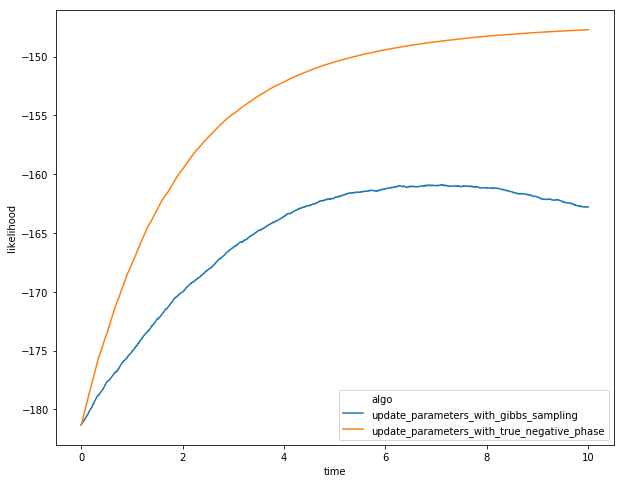

In [23]:
plt.figure(figsize=(10, 8))
ax = sns.lineplot(x="time", y="likelihood", hue="algo", legend='brief', data=df, ci=None)

In [35]:
# begin part 2

In [36]:
# using stochastic maximum likelihood to approximate negative phase
def update_parameters_with_sml(weights=weights, biases=biases, n_samples=100, init_sample=None):
    model_samples = gibbs_sampler(weights=weights, biases=biases, n_samples=n_samples, init_sample=init_sample)

    for i, j in var_combinations:
        # positive phase
        positive_phase = (data[:, i] * data[:, j]).mean()

        # negative phase
        negative_phase = (model_samples[:, i] * model_samples[:, j]).mean()

        # update weights
        weights[i, j] += alpha * (positive_phase - negative_phase)
        
    for i, _ in enumerate(biases):
        # positive phase
        positive_phase = data[:, i].mean()
        
        # negative phase
        negative_phase = model_samples[:, i].mean()
        
        # update biases
        biases[i] += alpha * (positive_phase - negative_phase)
        
    return np.array(weights), np.array(biases), model_samples[-1]

# run each for 100 epochs, plot progress

## stochastic maximum likelihood

In [37]:
init_sample = None
weights, biases = reset_parameters()

for i in range(100):
    weights, biases, init_sample = update_parameters_with_sml(weights=weights, biases=biases, init_sample=init_sample)
    
    lik = Model(weights=weights, biases=biases).likelihood(data, log=True)
    if i % 10 == 0:
        print(lik)

-181.30819308204985
-180.9944066279601
-180.76739118327933
-180.5329009178584
-180.3186431840651
-180.0480659876875
-179.839073071066
-179.582937353215
-179.33876082137095
-179.09070605650084


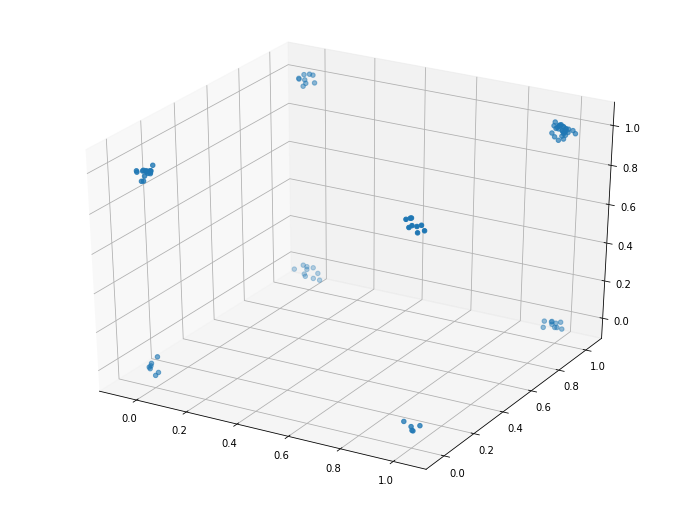

In [39]:
plot_n_samples(1000, weights=weights, biases=biases)